<a href="https://colab.research.google.com/github/yfpang7/dataScience_projects/blob/main/FNN_deepLearningCalculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [195]:
import polars as pl
import numpy as np
import polars.selectors as cs
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
import sklearn.metrics as skm

pl.Config.set_tbl_rows(100)

polars.config.Config

In [196]:
raw_data = (
    pl.DataFrame({
    'x1' : np.random.randint(low=-10, high=11, size=5000,).astype(np.float32),
    'x2' : np.random.randint(low=-10, high=11, size=5000).astype(np.float32),
    })
    .with_columns(
        label = pl.col('x1') + pl.col('x2')
    )
)

# select the features and label
features = raw_data.select('x1', 'x2').to_numpy()
label = raw_data['label'].to_numpy()

In [197]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.33, random_state=42)

In [198]:
# conver to tensors
X_trainT = torch.tensor(X_train, dtype=torch.float32)
X_testT = torch.tensor(X_test, dtype=torch.float32)
y_trainT = torch.tensor(y_train, dtype=torch.float32)
y_testT = torch.tensor(y_test, dtype=torch.float32)

In [199]:
# create pytorch dataset
train_dataset = TensorDataset(X_trainT, y_trainT)
test_dataset = TensorDataset(X_testT, y_testT)

In [200]:
# convert to DataLoader
batchSize = 32
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [201]:
# create the model and components
class ANNmodel(nn.Module):
  def __init__(self, input_size, nUnits, nLayers):
    super().__init__()

    # create a dictionary to store the layers
    self.layers = nn.ModuleDict()

    # create the input layer
    self.layers['input'] = nn.Linear(input_size, nUnits)

    # create the hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

    # output layer
    self.layers['output'] = nn.Linear(nUnits, 1)

  # forward pass
  def forward(self, x):
    x = F.relu(self.layers['input'](x))
    for i in range(len(self.layers)-2):
      x = F.relu(self.layers[f'hidden{i}'](x))

    # output layer
    x = self.layers['output'](x)

    return x

In [202]:
# test the class
ANNmodel(input_size=2, nUnits=32, nLayers=2)

ANNmodel(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=32, bias=True)
    (hidden0): Linear(in_features=32, out_features=32, bias=True)
    (hidden1): Linear(in_features=32, out_features=32, bias=True)
    (output): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [203]:
# create the model components
def createANNnet(input_size, nUnits, nLayers, learningRate=.01):
  model = ANNmodel(input_size, nUnits, nLayers)
  lossfunc = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=.95)
  return model, lossfunc, optimizer, scheduler

In [204]:
# define a function for training
def trainModel(train_loader, test_loader, input_size, nUnits, nLayers, numepochs=500, toggleDynamic=False):
  training_progress = pl.DataFrame(
      schema=[
          ('iteration', pl.Int64),
          ('epoch', pl.Int64),
          ('train_loss', pl.Float64),
          ('train_acc', pl.Float64),
          ('test_loss', pl.Float64),
          ('test_acc', pl.Float64),
          ('learning_rate', pl.Float64)
      ]
  )
  iteration = 0

  # create the ann model
  model, lossfunc, optimizer, scheduler = createANNnet(input_size, nUnits, nLayers)

  # early stopping parameters
  patience =  15
  best_loss = float('inf')
  no_improve_count = 0
  best_model = None

  # training loop
  for epoch in range(numepochs):
    model.train()
    epoch_train_loss = 0
    epoch_train_acc = 0
    num_batches = 0

    # iterate through the training batches
    for X_trainTL, y_trainTL in train_loader:
      yhat_train = model(X_trainTL)
      train_loss = lossfunc(yhat_train.squeeze(), y_trainTL)
      ## backpropagation
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      ## evaluate training accuracy using percentage error
      # train_acc = torch.mean(torch.abs((yhat_train.squeeze() - y_trainTL) / (y_trainTL + 1e-8))) * 100
      train_acc = torch.mean((torch.abs(yhat_train.squeeze() - y_trainTL) < 1).float()) * 100

      ## sum of the loss and accuracy
      epoch_train_loss += train_loss.item()
      epoch_train_acc += train_acc.item()
      num_batches += 1

      # Iteration for each batch
      iteration += 1

    ## update the learning rate after all batches (once per epoch) -  lr decay - if enabled
    if toggleDynamic:
      scheduler.step()
      current_lrs = scheduler.get_last_lr()[0]
    else:
      current_lrs = optimizer.param_groups[0]['lr']

    # evaluate test set
    model.eval()
    test_loss_total = 0
    test_acc_total = 0
    test_batches = 0

    with torch.no_grad():
      for X_testTL, y_testTL in test_loader:
        yhat_test = model(X_testTL)
        test_loss = lossfunc(yhat_test.squeeze(), y_testTL)

        # Calculate test accuracy using the same metric
        ## get the difference = yhat_test.squeeze() - y_testTL
        ## calculate the relative error as fraction = (yhat_test.squeeze() - y_testTL) / (y_testTL + 1e-8)
        ## get the absolute and average across all the samples in the batch
        # test_acc = torch.mean(torch.abs((yhat_test.squeeze() - y_testTL) / (y_testTL + 1e-8))) * 100
        # if the difference is less than 1 then be 1.0
        test_acc = torch.mean((torch.abs(yhat_test.squeeze() - y_testTL) < 1).float()) * 100

        test_loss_total += test_loss.item()
        test_acc_total += test_acc.item()
        test_batches += 1

    # Calculate average losses and accuracies for the epoch
    avg_train_loss = epoch_train_loss / num_batches
    avg_train_acc = epoch_train_acc / num_batches
    avg_test_loss = test_loss_total / test_batches
    avg_test_acc = test_acc_total / test_batches

    # Add to training progress
    new_row = pl.DataFrame([{
        'iteration': iteration,
        'epoch': epoch,
        'train_loss': avg_train_loss,
        'train_acc': avg_train_acc,
        'test_loss': avg_test_loss,
        'test_acc': avg_test_acc,
        'learning_rate': current_lrs
    }])
    training_progress = pl.concat([training_progress, new_row])

    # Early stopping check
    if avg_test_loss < best_loss:
      best_loss = avg_test_loss
      no_improve_count = 0
      best_model = copy.deepcopy(model.state_dict())
    else:
      no_improve_count += 1

    if no_improve_count >= patience:
      print(f"Early stopping at epoch {epoch}")
      break

    # Print progress occasionally
    if epoch % 50 == 0 or epoch == numepochs - 1:
      print(f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

  # Load best model
  if best_model is not None:
    model.load_state_dict(best_model)

  return training_progress, model



In [205]:
# train the model
training_progress, trained_model = trainModel(train_loader=train_loader, test_loader=test_loader, input_size=2, nUnits=32, nLayers=2, numepochs=500, toggleDynamic=False)



Epoch 0: Train Loss: 4.7124, Test Loss: 0.0111
Epoch 50: Train Loss: 0.0006, Test Loss: 0.0004
Early stopping at epoch 62


In [206]:
# test the model
training_progress.head()

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate
i64,i64,f64,f64,f64,f64,f64
104,0,4.71236,78.786058,0.011146,100.0,0.01
208,1,0.005453,100.0,0.003256,100.0,0.01
312,2,0.002273,100.0,0.001321,100.0,0.01
416,3,0.001501,100.0,0.000833,100.0,0.01
520,4,0.001173,100.0,0.001845,100.0,0.01


In [207]:
# run the model 20 times
final_training_progress = []

for i in range(12):
  # train the model
  print(f'Training model number: {i+1}')
  training_progress, trained_model = trainModel(train_loader=train_loader, test_loader=test_loader, input_size=2, nUnits=32, nLayers=2, numepochs=500, toggleDynamic=False)

  # annotate experiment number
  training_progress = (
      training_progress
      .with_columns(
          experiment_num=pl.lit(i)
      )
  )

  final_training_progress.append(training_progress)

data = pl.concat(final_training_progress)



Training model number: 1
Epoch 0: Train Loss: 5.2755, Test Loss: 0.0242
Epoch 50: Train Loss: 0.0006, Test Loss: 0.0009
Early stopping at epoch 52
Training model number: 2
Epoch 0: Train Loss: 6.4330, Test Loss: 0.0201
Early stopping at epoch 36
Training model number: 3
Epoch 0: Train Loss: 5.5941, Test Loss: 0.0102
Early stopping at epoch 49
Training model number: 4
Epoch 0: Train Loss: 4.9010, Test Loss: 0.0140
Early stopping at epoch 38
Training model number: 5
Epoch 0: Train Loss: 4.9908, Test Loss: 0.0113
Early stopping at epoch 40
Training model number: 6
Epoch 0: Train Loss: 4.2283, Test Loss: 0.0064
Epoch 50: Train Loss: 0.0005, Test Loss: 0.0003
Epoch 100: Train Loss: 0.0006, Test Loss: 0.0000
Early stopping at epoch 117
Training model number: 7
Epoch 0: Train Loss: 6.3693, Test Loss: 0.0383
Epoch 50: Train Loss: 0.0001, Test Loss: 0.0001
Early stopping at epoch 98
Training model number: 8
Epoch 0: Train Loss: 5.8721, Test Loss: 0.0421
Early stopping at epoch 31
Training model

In [208]:
# inspect the final training data
data.head()

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate,experiment_num
i64,i64,f64,f64,f64,f64,f64,i32
104,0,5.275493,80.228365,0.024242,100.0,0.01,0
208,1,0.009082,100.0,0.007749,100.0,0.01,0
312,2,0.004224,100.0,0.002341,100.0,0.01,0
416,3,0.00231,100.0,0.002241,100.0,0.01,0
520,4,0.006828,100.0,0.001509,100.0,0.01,0


In [209]:
# evaluate the whole dataset and compute the accuracy
with torch.no_grad():
  predictions = trained_model(torch.tensor(features, dtype=torch.float32))


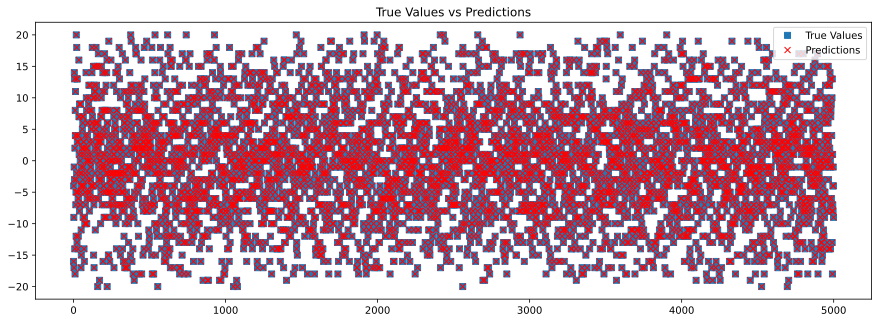

In [210]:
fig = plt.figure(figsize=(15,5))

plt.plot(label, 's', label='True Values')
plt.plot(np.round(predictions.detach().numpy()), 'rx', label='Predictions')
plt.legend()
plt.title('True Values vs Predictions')
plt.show()

In [211]:
predictions.detach().squeeze()

tensor([-16.0113,  -3.9801,  -8.9840,  ...,  -1.0180,  -3.9808,  -9.0192])

In [212]:
predictions_data = pl.DataFrame({
    'features' : features,
    'label' : label,
    'predictions' : np.array(predictions.detach().squeeze()),
    'predictions_rounded' : np.round(np.array(predictions.detach().squeeze()))
}).explode('features')

In [213]:
# check if the predictions == label
predictions_data = (
    predictions_data
    .with_columns(
        correct_prediction=pl.when(pl.col('label') == pl.col('predictions_rounded'))
        .then(True)
        .otherwise(False)
    )
)

predictions_data.head()

features,label,predictions,predictions_rounded,correct_prediction
f32,f32,f32,f32,bool
-7.0,-16.0,-16.01132,-16.0,true
-9.0,-16.0,-16.01132,-16.0,true
-9.0,-4.0,-3.980116,-4.0,true
5.0,-4.0,-3.980116,-4.0,true
-10.0,-9.0,-8.983951,-9.0,true


In [214]:
fig = px.scatter(
    data_frame=predictions_data,
    x='label',
    y='predictions_rounded',
    color='correct_prediction'
)

fig.update_layout(template='ggplot2', width=600)
fig.show()

In [215]:
data.head()

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate,experiment_num
i64,i64,f64,f64,f64,f64,f64,i32
104,0,5.275493,80.228365,0.024242,100.0,0.01,0
208,1,0.009082,100.0,0.007749,100.0,0.01,0
312,2,0.004224,100.0,0.002341,100.0,0.01,0
416,3,0.00231,100.0,0.002241,100.0,0.01,0
520,4,0.006828,100.0,0.001509,100.0,0.01,0


In [222]:
fig = px.scatter(
    data_frame=data,
    x='epoch',
    y=['train_loss' ,'test_loss'],
    facet_col='experiment_num',
    facet_col_wrap=3
)

fig.update_layout(template='ggplot2', width=1000, height=1500)
fig.update_traces(marker=dict(opacity=0.6, line=dict(width=.2, color='darkslategray')))

fig.show()

In [217]:
data.head(1)

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate,experiment_num
i64,i64,f64,f64,f64,f64,f64,i32
104,0,5.275493,80.228365,0.024242,100.0,0.01,0


In [218]:
# groupby
summary_data = (
    data
    .group_by('experiment_num')
    .agg(pl.exclude('iteration', 'learning_rate').mean().name.prefix('mean_'))
)
print(summary_data.shape)
summary_data.head()

(12, 6)


experiment_num,mean_epoch,mean_train_loss,mean_train_acc,mean_test_loss,mean_test_acc
i32,f64,f64,f64,f64,f64
0,26.0,0.116943,99.33384,0.011536,99.836478
1,18.0,0.185785,99.093685,0.005153,100.0
2,24.5,0.123704,99.453726,0.011892,99.887273
3,19.0,0.166277,98.867419,0.017042,99.575758
4,20.0,0.14495,99.079503,0.013147,99.827051


In [219]:
summary_data_melt = (
    summary_data
    .select(pl.exclude('mean_epoch'))
    .unpivot(
        index='experiment_num',
        variable_name='performance_metrics',
    )
)

summary_data_melt.head(2)

experiment_num,performance_metrics,value
i32,str,f64
0,"""mean_train_loss""",0.116943
1,"""mean_train_loss""",0.185785


In [220]:
px.bar(
    data_frame=(
        summary_data_melt
        .sort('experiment_num', descending=False)
        .filter(
            pl.col('performance_metrics').str.contains('acc')
        )
        ),
    x='performance_metrics',
    y='value',
    facet_col='experiment_num',
    facet_col_wrap=4
).update_layout(template='ggplot2', width=800, height=1200)